# ASL Alphabet Classification with ResNet-18 Transfer Learning
### By: Munish Shah - DAEN 429 Course Project (Phase 1)

## 1. Setup & Imports

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
import os
import json
from PIL import Image
from tqdm import tqdm
import copy
import warnings

SEED = 429 #Required Seed 
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

DEVICE = torch.device('cuda')

print(f'Using device: {DEVICE}')

Using device: cuda


## 2. Mount Google Drive & Extract Data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

PROJECT_DIR = '/content/drive/My Drive/ASL_Project'
CHECKPOINT_DIR = f'{PROJECT_DIR}/checkpoints'
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

Mounted at /content/drive


In [ ]:
if not os.path.exists('data/asl_alphabet_train'): #I put my data in google drive and extract in colab
    !cp "{PROJECT_DIR}/data.zip" .
    !unzip -q data.zip
    !rm data.zip
    print('Data extracted!')

Data extracted!
asl_alphabet_test  asl_alphabet_train  asl_custom_test


## 3. Configuration

In [ ]:
DATA_DIR = 'data/asl_alphabet_train/asl_alphabet_train'
TEST_DIR = 'data/asl_alphabet_test/asl_alphabet_test'
CUSTOM_TEST_DIR = 'data/asl_custom_test'

os.makedirs(CUSTOM_TEST_DIR, exist_ok=True)

IMG_SIZE = 224 #Resnet input size
NUM_CLASSES = 29 #Number of classes

IMAGENET_MEAN = [0.485, 0.456, 0.406] 
IMAGENET_STD = [0.229, 0.224, 0.225]

# Hyperparameter search space
HP_LEARNING_RATES = [1e-2, 1e-3, 1e-4] #Learning rates to try
HP_BATCH_SIZES = [128] 
HP_TUNING_EPOCHS = 3
FINAL_EPOCHS = 7

print(f'Data directory exists: {os.path.exists(DATA_DIR)}')
print(f'Test directory exists: {os.path.exists(TEST_DIR)}')

Data directory exists: True
Test directory exists: True


## 4. ResNet-18 Architecture Exploration

In [6]:
resnet18 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

print("ResNet-18 Architecture:")
print("=" * 60)
for name, module in resnet18.named_children():
    params = sum(p.numel() for p in module.parameters())
    print(f"{name:12s}: {params:>10,} parameters")

total = sum(p.numel() for p in resnet18.parameters())
print("=" * 60)
print(f"{'TOTAL':12s}: {total:>10,} parameters")
print(f"\nOriginal fc layer: {resnet18.fc.in_features} -> {resnet18.fc.out_features}")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 239MB/s]


ResNet-18 Architecture:
conv1       :      9,408 parameters
bn1         :        128 parameters
relu        :          0 parameters
maxpool     :          0 parameters
layer1      :    147,968 parameters
layer2      :    525,568 parameters
layer3      :  2,099,712 parameters
layer4      :  8,393,728 parameters
avgpool     :          0 parameters
fc          :    513,000 parameters
TOTAL       : 11,689,512 parameters

Original fc layer: 512 -> 1000


## 5. Data Loading & Preprocessing

In [ ]:
#transformations for data augmentation
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)), #Resize the image to 224x224 (res inputsize)
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomRotation(10), 
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

val_transform = transforms.Compose([transforms.Resize((IMG_SIZE, IMG_SIZE)),transforms.ToTensor(),transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)])

full_dataset = datasets.ImageFolder(DATA_DIR, transform=train_transform)
print(f"Total images: {len(full_dataset)}")
print(f"Classes ({len(full_dataset.classes)}): {full_dataset.classes}")

Total images: 87000
Classes (29): ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


In [ ]:
indices = np.arange(len(full_dataset))
labels = np.array([full_dataset.targets[i] for i in indices])

train_idx, val_idx = train_test_split(indices, test_size=0.2, stratify=labels, random_state=429)

print(f"Training samples: {len(train_idx)}")
print(f"Validation samples: {len(val_idx)}")

Training samples: 69600
Validation samples: 17400


In [ ]:
def create_data_loaders(batch_size): 
    train_dataset_raw = datasets.ImageFolder(DATA_DIR, transform=train_transform)
    val_dataset_raw = datasets.ImageFolder(DATA_DIR, transform=val_transform)

    train_dataset = Subset(train_dataset_raw, train_idx)
    val_dataset = Subset(val_dataset_raw, val_idx)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=9, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=9, pin_memory=True)

    return train_loader, val_loader

## 6. Helper Functions

In [ ]:
def set_requires_grad(module, requires_grad): # 'set_requires_grad': Utility to freeze/unfreeze layers efficiently.
    for param in module.parameters():
        param.requires_grad = requires_grad

def count_trainable_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def create_model(pretrained=True):
    if pretrained:
        model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    else:
        model = models.resnet18(weights=None)
    model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
    return model.to(DEVICE)

def set_bn_eval(model): # 'set_bn_eval': Critical for transfer learning; keeps BatchNorm layers in eval mode even during training to preserve pretrained statistics.
    for module in model.modules():
        if isinstance(module, nn.BatchNorm2d):
            module.eval()

def save_checkpoint(model, name, history=None):
    path = f'{CHECKPOINT_DIR}/{name}.pt'
    torch.save(model.state_dict(), path)
    if history is not None:
        with open(f'{CHECKPOINT_DIR}/{name}_history.json', 'w') as f:
            json.dump(history, f)
    print(f'Saved: {path}')

def load_checkpoint(model, name):
    path = f'{CHECKPOINT_DIR}/{name}.pt'
    if os.path.exists(path):
        model.load_state_dict(torch.load(path, map_location=DEVICE))
        print(f'Loaded: {path}')
        return True
    return False

def load_history(name):
    path = f'{CHECKPOINT_DIR}/{name}_history.json'
    if os.path.exists(path):
        with open(path, 'r') as f:
            return json.load(f)
    return None

def checkpoint_exists(name):
    return os.path.exists(f'{CHECKPOINT_DIR}/{name}.pt')

## 7. Training & Evaluation Functions

In [ ]:
criterion = nn.CrossEntropyLoss()
# Implement standard training loop with CrossEntropyLoss.
def train_one_epoch(model, loader, optimizer, freeze_bn=False):
    model.train()
    if freeze_bn:
        set_bn_eval(model)

    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(loader, desc='Training', leave=False):
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    return running_loss / total, correct / total

@torch.no_grad()
def evaluate(model, loader): # 'evaluate' function calculates Macro-F1 score, the primary metric for model selection.
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    for images, labels in tqdm(loader, desc='Evaluating', leave=False):
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    loss = running_loss / len(all_labels)
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')

    return loss, acc, f1, np.array(all_preds), np.array(all_labels)

def train_model(model, train_loader, val_loader, optimizer, epochs, config_name, freeze_bn=False):
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'val_f1': []}
    best_f1 = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())

    print(f"\n{'='*60}")
    print(f"Training: {config_name}")
    print(f"Trainable parameters: {count_trainable_params(model):,}")
    print(f"{'='*60}")

    for epoch in range(1, epochs + 1):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, freeze_bn)
        val_loss, val_acc, val_f1, _, _ = evaluate(model, val_loader)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_f1'].append(val_f1)

        if val_f1 > best_f1:
            best_f1 = val_f1
            best_model_wts = copy.deepcopy(model.state_dict())

        print(f"Epoch {epoch:2d}/{epochs} | Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f} F1: {val_f1:.4f}")

    model.load_state_dict(best_model_wts)
    return model, history, best_f1

## 8. Hyperparameter Tuning Functions

In [ ]:
def setup_model_config(config_name, pretrained_weights=None): # Dynamically freezes layers based on the configuration (T-A, T-B, T-C).
    if config_name == 'S-A':
        model = create_model(pretrained=False)
    else:
        model = create_model(pretrained=True)
        if pretrained_weights is not None:
            model.load_state_dict(pretrained_weights)
            print(f"Loaded weights from previous config")

    if config_name == 'T-A':
        set_requires_grad(model, False)
        set_requires_grad(model.fc, True)
    elif config_name == 'T-B':
        set_requires_grad(model, False)
        set_requires_grad(model.layer4, True)
        set_requires_grad(model.fc, True)
    elif config_name == 'T-C':
        set_requires_grad(model, False)
        set_requires_grad(model.layer3, True)
        set_requires_grad(model.layer4, True)
        set_requires_grad(model.fc, True)

    return model

def tune_hyperparameters(config_name, pretrained_weights=None): #Tunes hyperparameters for a given configuration.
    print(f"\n{'#'*60}")
    print(f"Hyperparameter Tuning: {config_name}")
    print(f"{'#'*60}")

    results = []
    freeze_bn = config_name in ['T-A', 'T-B', 'T-C']

    for lr in HP_LEARNING_RATES:
        for bs in HP_BATCH_SIZES:
            print(f"\nTrying lr={lr}, batch_size={bs}")

            model = setup_model_config(config_name, pretrained_weights)
            train_loader, val_loader = create_data_loaders(bs)
            optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

            _, _, best_f1 = train_model(
                model, train_loader, val_loader, optimizer,
                HP_TUNING_EPOCHS, f"{config_name} (lr={lr}, bs={bs})", freeze_bn
            )

            results.append({'lr': lr, 'batch_size': bs, 'val_f1': best_f1})

    best = max(results, key=lambda x: x['val_f1'])
    print(f"\n>>> Best for {config_name}: lr={best['lr']}, bs={best['batch_size']}, F1={best['val_f1']:.4f}")

    return best, results

all_hp_results = {}
best_hps = {}

## 9. T-A: Head-Only Fine-Tuning

In [13]:
best_hps['T-A'], all_hp_results['T-A'] = tune_hyperparameters('T-A')


############################################################
Hyperparameter Tuning: T-A
############################################################

Trying lr=0.01, batch_size=128

Training: T-A (lr=0.01, bs=128)
Trainable parameters: 14,877


Epoch  1/3 | Train Loss: 0.7229 Acc: 0.7992 | Val Loss: 0.2973 Acc: 0.9082 F1: 0.9096


Epoch  2/3 | Train Loss: 0.3256 Acc: 0.8963 | Val Loss: 0.2514 Acc: 0.9166 F1: 0.9165


Epoch  3/3 | Train Loss: 0.2656 Acc: 0.9116 | Val Loss: 0.2028 Acc: 0.9319 F1: 0.9311

Trying lr=0.001, batch_size=128

Training: T-A (lr=0.001, bs=128)
Trainable parameters: 14,877


Epoch  1/3 | Train Loss: 1.4236 Acc: 0.7039 | Val Loss: 0.7288 Acc: 0.8364 F1: 0.8338


Epoch  2/3 | Train Loss: 0.6386 Acc: 0.8641 | Val Loss: 0.4684 Acc: 0.8912 F1: 0.8903


Epoch  3/3 | Train Loss: 0.4671 Acc: 0.8965 | Val Loss: 0.3591 Acc: 0.9141 F1: 0.9139

Trying lr=0.0001, batch_size=128

Training: T-A (lr=0.0001, bs=128)
Trainable parameters: 14,877


Epoch  1/3 | Train Loss: 2.8647 Acc: 0.3262 | Val Loss: 2.3170 Acc: 0.5624 F1: 0.5332


Epoch  2/3 | Train Loss: 2.0580 Acc: 0.6525 | Val Loss: 1.7281 Acc: 0.6810 F1: 0.6697


Epoch  3/3 | Train Loss: 1.6173 Acc: 0.7394 | Val Loss: 1.3711 Acc: 0.7602 F1: 0.7536

>>> Best for T-A: lr=0.01, bs=128, F1=0.9311


In [14]:
if checkpoint_exists('T-A_best'):
    model_ta = create_model(pretrained=True)
    load_checkpoint(model_ta, 'T-A_best')
    history_ta = load_history('T-A_best')
else:
    hp = best_hps['T-A']
    model_ta = setup_model_config('T-A')
    train_loader, val_loader = create_data_loaders(hp['batch_size'])
    optimizer_ta = optim.Adam(filter(lambda p: p.requires_grad, model_ta.parameters()), lr=hp['lr'])

    model_ta, history_ta, best_f1_ta = train_model(
        model_ta, train_loader, val_loader, optimizer_ta,
        FINAL_EPOCHS, "T-A: Head-Only", freeze_bn=True
    )
    save_checkpoint(model_ta, 'T-A_best', history_ta)
    print(f"\nT-A Best Validation F1: {best_f1_ta:.4f}")


Training: T-A: Head-Only
Trainable parameters: 14,877


Epoch  1/7 | Train Loss: 0.7150 Acc: 0.8006 | Val Loss: 0.3260 Acc: 0.8968 F1: 0.8962


Epoch  2/7 | Train Loss: 0.3112 Acc: 0.9006 | Val Loss: 0.2547 Acc: 0.9149 F1: 0.9151


Epoch  3/7 | Train Loss: 0.2706 Acc: 0.9097 | Val Loss: 0.2178 Acc: 0.9261 F1: 0.9262


Epoch  4/7 | Train Loss: 0.2421 Acc: 0.9185 | Val Loss: 0.2380 Acc: 0.9194 F1: 0.9186


Epoch  5/7 | Train Loss: 0.2425 Acc: 0.9202 | Val Loss: 0.1612 Acc: 0.9450 F1: 0.9450


Epoch  6/7 | Train Loss: 0.2232 Acc: 0.9258 | Val Loss: 0.1800 Acc: 0.9368 F1: 0.9384


Epoch  7/7 | Train Loss: 0.2132 Acc: 0.9292 | Val Loss: 0.2013 Acc: 0.9340 F1: 0.9344
Saved: /content/drive/My Drive/ASL_Project/checkpoints/T-A_best.pt

T-A Best Validation F1: 0.9450


## 10. T-B: Last Block Fine-Tuning (layer4 + fc)

In [15]:
best_hps['T-B'], all_hp_results['T-B'] = tune_hyperparameters('T-B')


############################################################
Hyperparameter Tuning: T-B
############################################################

Trying lr=0.01, batch_size=128

Training: T-B (lr=0.01, bs=128)
Trainable parameters: 8,408,605


Epoch  1/3 | Train Loss: 101.1727 Acc: 0.1250 | Val Loss: 2.0906 Acc: 0.3241 F1: 0.2820


Epoch  2/3 | Train Loss: 3.0815 Acc: 0.1205 | Val Loss: 3.3675 Acc: 0.0345 F1: 0.0023


Epoch  3/3 | Train Loss: 3.3682 Acc: 0.0330 | Val Loss: 3.3682 Acc: 0.0345 F1: 0.0023

Trying lr=0.001, batch_size=128

Training: T-B (lr=0.001, bs=128)
Trainable parameters: 8,408,605


Epoch  1/3 | Train Loss: 3.3707 Acc: 0.0341 | Val Loss: 3.3674 Acc: 0.0345 F1: 0.0023


Epoch  2/3 | Train Loss: 3.3675 Acc: 0.0324 | Val Loss: 3.3673 Acc: 0.0345 F1: 0.0023


Epoch  3/3 | Train Loss: 3.3675 Acc: 0.0338 | Val Loss: 3.3673 Acc: 0.0345 F1: 0.0023

Trying lr=0.0001, batch_size=128

Training: T-B (lr=0.0001, bs=128)
Trainable parameters: 8,408,605


Epoch  1/3 | Train Loss: 0.2405 Acc: 0.9314 | Val Loss: 0.0191 Acc: 0.9948 F1: 0.9948


Epoch  2/3 | Train Loss: 0.0208 Acc: 0.9938 | Val Loss: 0.0042 Acc: 0.9990 F1: 0.9990


Epoch  3/3 | Train Loss: 0.0125 Acc: 0.9965 | Val Loss: 0.0058 Acc: 0.9983 F1: 0.9983

>>> Best for T-B: lr=0.0001, bs=128, F1=0.9990


In [22]:
if checkpoint_exists('T-B_best'):
    model_tb = create_model(pretrained=True)
    load_checkpoint(model_tb, 'T-B_best')
    history_tb = load_history('T-B_best')
else:
    hp = best_hps['T-B']
    model_tb = setup_model_config('T-B')
    train_loader, val_loader = create_data_loaders(hp['batch_size'])
    optimizer_tb = optim.Adam(filter(lambda p: p.requires_grad, model_tb.parameters()), lr=hp['lr'])

    model_tb, history_tb, best_f1_tb = train_model(
        model_tb, train_loader, val_loader, optimizer_tb,
        FINAL_EPOCHS, "T-B: Layer4 + FC", freeze_bn=True
    )
    save_checkpoint(model_tb, 'T-B_best', history_tb)
    print(f"\nT-B Best Validation F1: {best_f1_tb:.4f}")


Training: T-B: Layer4 + FC
Trainable parameters: 8,408,605


Epoch  1/7 | Train Loss: 0.2232 Acc: 0.9363 | Val Loss: 0.0249 Acc: 0.9916 F1: 0.9916


Epoch  2/7 | Train Loss: 0.0215 Acc: 0.9937 | Val Loss: 0.0076 Acc: 0.9984 F1: 0.9984


Epoch  3/7 | Train Loss: 0.0138 Acc: 0.9959 | Val Loss: 0.0017 Acc: 0.9997 F1: 0.9997


Epoch  4/7 | Train Loss: 0.0109 Acc: 0.9969 | Val Loss: 0.0060 Acc: 0.9978 F1: 0.9978


Epoch  5/7 | Train Loss: 0.0053 Acc: 0.9985 | Val Loss: 0.0013 Acc: 0.9997 F1: 0.9997


Epoch  6/7 | Train Loss: 0.0075 Acc: 0.9978 | Val Loss: 0.0004 Acc: 0.9999 F1: 0.9999


Epoch  7/7 | Train Loss: 0.0058 Acc: 0.9983 | Val Loss: 0.0036 Acc: 0.9987 F1: 0.9987
Saved: /content/drive/My Drive/ASL_Project/checkpoints/T-B_best.pt

T-B Best Validation F1: 0.9999


## 11. T-C: Progressive Unfreezing (from T-B)

In [23]:
# T-C starts from T-B's trained weights
tb_weights = copy.deepcopy(model_tb.state_dict())
best_hps['T-C'], all_hp_results['T-C'] = tune_hyperparameters('T-C', pretrained_weights=tb_weights)


############################################################
Hyperparameter Tuning: T-C
############################################################

Trying lr=0.01, batch_size=128
Loaded weights from previous config

Training: T-C (lr=0.01, bs=128)
Trainable parameters: 10,508,317


Epoch  1/3 | Train Loss: 339548.3361 Acc: 0.0395 | Val Loss: 3.4264 Acc: 0.0479 F1: 0.0102


Epoch  2/3 | Train Loss: 34914.1923 Acc: 0.0383 | Val Loss: 3.3756 Acc: 0.0345 F1: 0.0023


Epoch  3/3 | Train Loss: 3.3695 Acc: 0.0332 | Val Loss: 3.3675 Acc: 0.0345 F1: 0.0023

Trying lr=0.001, batch_size=128
Loaded weights from previous config

Training: T-C (lr=0.001, bs=128)
Trainable parameters: 10,508,317


Epoch  1/3 | Train Loss: 4.8634 Acc: 0.0359 | Val Loss: 3.3674 Acc: 0.0345 F1: 0.0023


Epoch  2/3 | Train Loss: 3.3675 Acc: 0.0333 | Val Loss: 3.3673 Acc: 0.0345 F1: 0.0023


Epoch  3/3 | Train Loss: 3.3675 Acc: 0.0327 | Val Loss: 3.3673 Acc: 0.0345 F1: 0.0023

Trying lr=0.0001, batch_size=128
Loaded weights from previous config

Training: T-C (lr=0.0001, bs=128)
Trainable parameters: 10,508,317


Epoch  1/3 | Train Loss: 0.0174 Acc: 0.9948 | Val Loss: 0.0007 Acc: 0.9998 F1: 0.9998


Epoch  2/3 | Train Loss: 0.0048 Acc: 0.9985 | Val Loss: 0.0047 Acc: 0.9985 F1: 0.9985


Epoch  3/3 | Train Loss: 0.0119 Acc: 0.9965 | Val Loss: 0.0035 Acc: 0.9987 F1: 0.9987

>>> Best for T-C: lr=0.0001, bs=128, F1=0.9998


In [24]:
if checkpoint_exists('T-C_best'):
    model_tc = create_model(pretrained=True)
    load_checkpoint(model_tc, 'T-C_best')
    history_tc = load_history('T-C_best')
else:
    hp = best_hps['T-C']
    model_tc = setup_model_config('T-C', pretrained_weights=tb_weights)

    train_loader, val_loader = create_data_loaders(hp['batch_size'])
    optimizer_tc = optim.Adam(filter(lambda p: p.requires_grad, model_tc.parameters()), lr=hp['lr'])

    model_tc, history_tc, best_f1_tc = train_model(
        model_tc, train_loader, val_loader, optimizer_tc,
        FINAL_EPOCHS, "T-C: Progressive (from T-B)", freeze_bn=True
    )
    save_checkpoint(model_tc, 'T-C_best', history_tc)
    print(f"\nT-C Best Validation F1: {best_f1_tc:.4f}")

Loaded weights from previous config

Training: T-C: Progressive (from T-B)
Trainable parameters: 10,508,317


Epoch  1/7 | Train Loss: 0.0153 Acc: 0.9953 | Val Loss: 0.0148 Acc: 0.9951 F1: 0.9950


Epoch  2/7 | Train Loss: 0.0088 Acc: 0.9973 | Val Loss: 0.0015 Acc: 0.9995 F1: 0.9995


Epoch  3/7 | Train Loss: 0.0074 Acc: 0.9979 | Val Loss: 0.0003 Acc: 0.9999 F1: 0.9999


Epoch  4/7 | Train Loss: 0.0066 Acc: 0.9979 | Val Loss: 0.0040 Acc: 0.9986 F1: 0.9986


Epoch  5/7 | Train Loss: 0.0077 Acc: 0.9977 | Val Loss: 0.0039 Acc: 0.9989 F1: 0.9989


Epoch  6/7 | Train Loss: 0.0045 Acc: 0.9988 | Val Loss: 0.0001 Acc: 0.9999 F1: 0.9999


Epoch  7/7 | Train Loss: 0.0014 Acc: 0.9996 | Val Loss: 0.0008 Acc: 0.9998 F1: 0.9998
Saved: /content/drive/My Drive/ASL_Project/checkpoints/T-C_best.pt

T-C Best Validation F1: 0.9999


## 12. S-A: Training From Scratch

In [25]:
best_hps['S-A'], all_hp_results['S-A'] = tune_hyperparameters('S-A')


############################################################
Hyperparameter Tuning: S-A
############################################################

Trying lr=0.01, batch_size=128

Training: S-A (lr=0.01, bs=128)
Trainable parameters: 11,191,389


Epoch  1/3 | Train Loss: 1.5664 Acc: 0.5295 | Val Loss: 0.2378 Acc: 0.9214 F1: 0.9230


Epoch  2/3 | Train Loss: 0.1019 Acc: 0.9649 | Val Loss: 0.0894 Acc: 0.9690 F1: 0.9697


Epoch  3/3 | Train Loss: 0.0510 Acc: 0.9832 | Val Loss: 0.0566 Acc: 0.9810 F1: 0.9810

Trying lr=0.001, batch_size=128

Training: S-A (lr=0.001, bs=128)
Trainable parameters: 11,191,389


Epoch  1/3 | Train Loss: 0.5600 Acc: 0.8290 | Val Loss: 0.2434 Acc: 0.9225 F1: 0.9187


Epoch  2/3 | Train Loss: 0.0595 Acc: 0.9822 | Val Loss: 0.1403 Acc: 0.9536 F1: 0.9525


Epoch  3/3 | Train Loss: 0.0312 Acc: 0.9900 | Val Loss: 0.0783 Acc: 0.9763 F1: 0.9763

Trying lr=0.0001, batch_size=128

Training: S-A (lr=0.0001, bs=128)
Trainable parameters: 11,191,389


Epoch  1/3 | Train Loss: 0.9380 Acc: 0.7371 | Val Loss: 0.2410 Acc: 0.9305 F1: 0.9287


Epoch  2/3 | Train Loss: 0.0868 Acc: 0.9802 | Val Loss: 0.0899 Acc: 0.9732 F1: 0.9730


Epoch  3/3 | Train Loss: 0.0371 Acc: 0.9919 | Val Loss: 0.0636 Acc: 0.9821 F1: 0.9821

>>> Best for S-A: lr=0.0001, bs=128, F1=0.9821


In [26]:
if checkpoint_exists('S-A_best'):
    model_sa = create_model(pretrained=False)
    load_checkpoint(model_sa, 'S-A_best')
    history_sa = load_history('S-A_best')
else:
    hp = best_hps['S-A']
    model_sa = setup_model_config('S-A')
    train_loader, val_loader = create_data_loaders(hp['batch_size'])
    optimizer_sa = optim.Adam(model_sa.parameters(), lr=hp['lr'])

    model_sa, history_sa, best_f1_sa = train_model(
        model_sa, train_loader, val_loader, optimizer_sa,
        FINAL_EPOCHS, "S-A: From Scratch", freeze_bn=False
    )
    save_checkpoint(model_sa, 'S-A_best', history_sa)
    print(f"\nS-A Best Validation F1: {best_f1_sa:.4f}")


Training: S-A: From Scratch
Trainable parameters: 11,191,389


Epoch  1/7 | Train Loss: 1.0260 Acc: 0.7091 | Val Loss: 0.1960 Acc: 0.9474 F1: 0.9480


Epoch  2/7 | Train Loss: 0.0968 Acc: 0.9780 | Val Loss: 0.0483 Acc: 0.9857 F1: 0.9854


Epoch  3/7 | Train Loss: 0.0412 Acc: 0.9905 | Val Loss: 0.0628 Acc: 0.9779 F1: 0.9778


Epoch  4/7 | Train Loss: 0.0253 Acc: 0.9944 | Val Loss: 0.0252 Acc: 0.9926 F1: 0.9926


Epoch  5/7 | Train Loss: 0.0200 Acc: 0.9955 | Val Loss: 0.0463 Acc: 0.9834 F1: 0.9825


Epoch  6/7 | Train Loss: 0.0185 Acc: 0.9951 | Val Loss: 0.0079 Acc: 0.9983 F1: 0.9983


Epoch  7/7 | Train Loss: 0.0155 Acc: 0.9961 | Val Loss: 0.0291 Acc: 0.9912 F1: 0.9913
Saved: /content/drive/My Drive/ASL_Project/checkpoints/S-A_best.pt

S-A Best Validation F1: 0.9983


In [27]:
hp_df = []
for config, results in all_hp_results.items():
    for r in results:
        hp_df.append({'config': config, **r})
hp_df = pd.DataFrame(hp_df)
hp_df.to_csv(f'{PROJECT_DIR}/hp_tuning_results.csv', index=False)
print("HP results saved to hp_tuning_results.csv")
hp_df

HP results saved to hp_tuning_results.csv


,config,lr,batch_size,val_f1
0,T-A,0.0100,128,0.931094
1,T-A,0.0010,128,0.913937
2,T-A,0.0001,128,0.753581
3,T-B,0.0100,128,0.282021
4,T-B,0.0010,128,0.002299
5,T-B,0.0001,128,0.998966
6,T-C,0.0100,128,0.010190
7,T-C,0.0010,128,0.002299
8,T-C,0.0001,128,0.999828
9,S-A,0.0100,128,0.981028


## 13. Training & Validation Curves

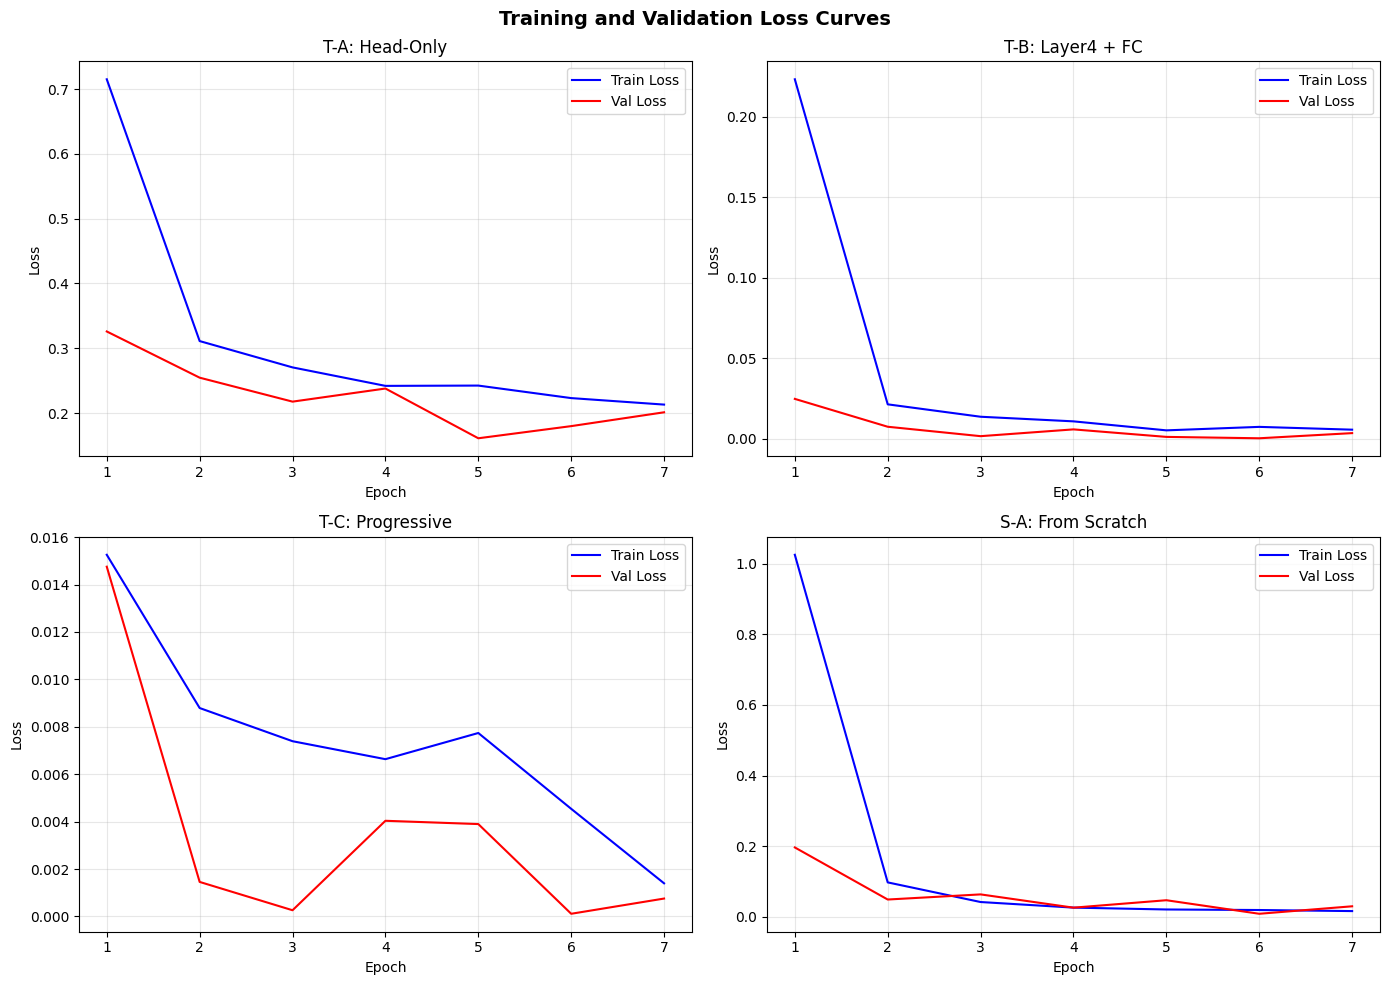

In [ ]:
histories = {  # Plot Loss and Accuracy curves to visualize convergence rates and check for overfitting across strategies.
    'T-A: Head-Only': history_ta,
    'T-B: Layer4 + FC': history_tb,
    'T-C: Progressive': history_tc,
    'S-A: From Scratch': history_sa
}

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
for ax, (name, history) in zip(axes.flat, histories.items()):
    if history is None:
        ax.set_title(f'{name} (no history)')
        continue
    epochs_range = range(1, len(history['train_loss']) + 1)
    ax.plot(epochs_range, history['train_loss'], 'b-', label='Train Loss')
    ax.plot(epochs_range, history['val_loss'], 'r-', label='Val Loss')
    ax.set_title(name)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle('Training and Validation Loss Curves', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{PROJECT_DIR}/loss_curves.png', dpi=150)
plt.show()

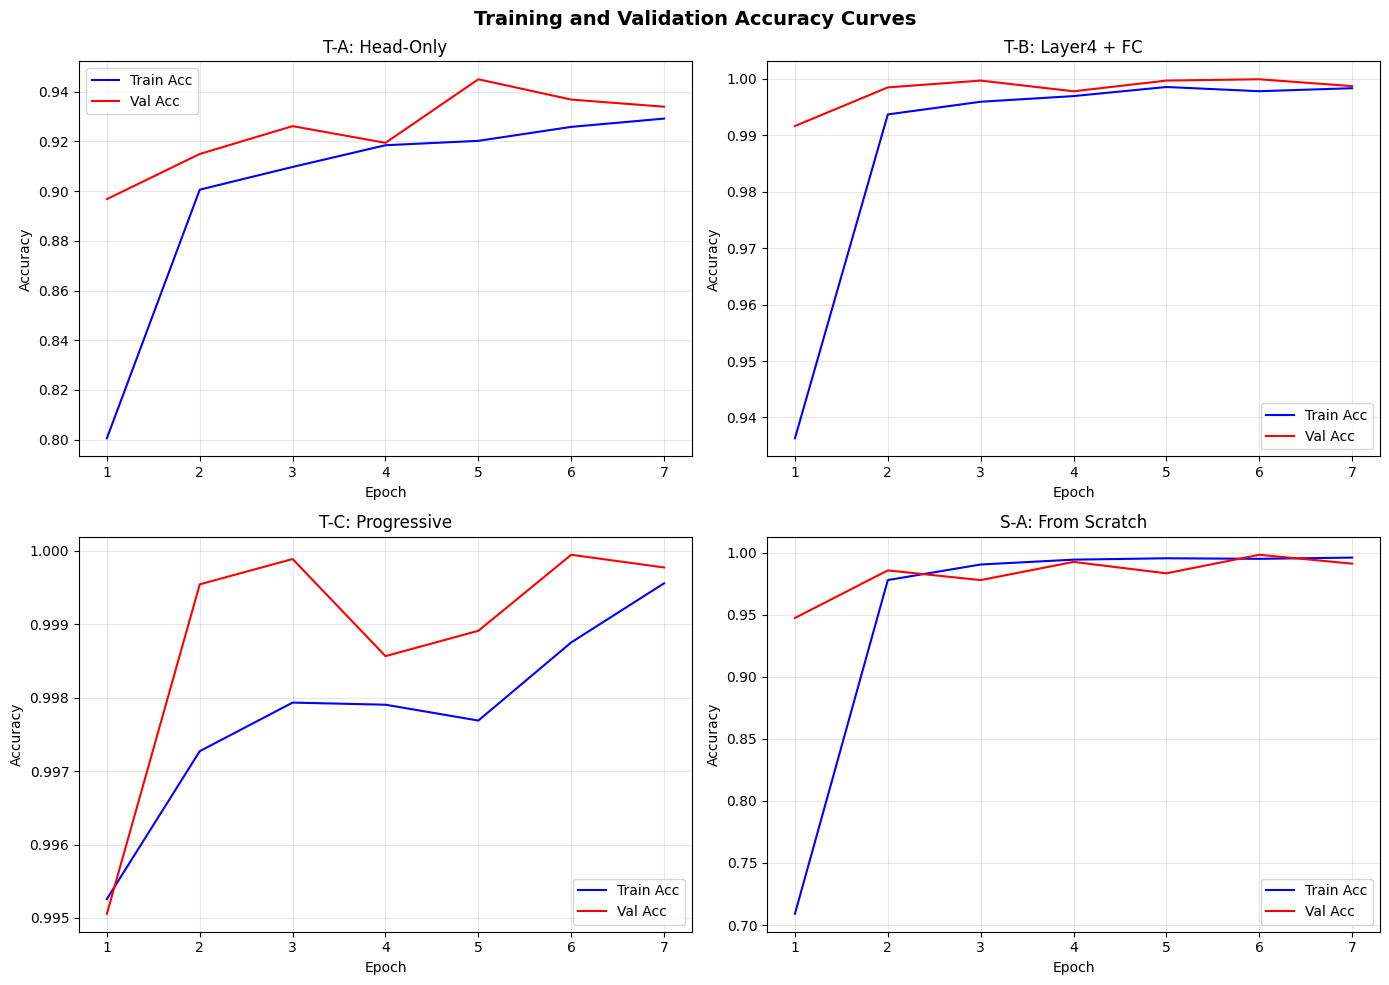

In [29]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
for ax, (name, history) in zip(axes.flat, histories.items()):
    if history is None:
        ax.set_title(f'{name} (no history)')
        continue
    epochs_range = range(1, len(history['train_acc']) + 1)
    ax.plot(epochs_range, history['train_acc'], 'b-', label='Train Acc')
    ax.plot(epochs_range, history['val_acc'], 'r-', label='Val Acc')
    ax.set_title(name)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle('Training and Validation Accuracy Curves', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{PROJECT_DIR}/accuracy_curves.png', dpi=150)
plt.show()

## 14. Evaluate All Models

In [ ]:
_, val_loader = create_data_loaders(64)
# evaluate models
models_dict = {
    'T-A (Head-Only)': model_ta,
    'T-B (Layer4 + FC)': model_tb,
    'T-C (Progressive)': model_tc,
    'S-A (From Scratch)': model_sa
}
results = {}
for name, model in models_dict.items():
    _, acc, f1, _, _ = evaluate(model, val_loader)
    results[name] = {'accuracy': acc, 'macro_f1': f1}
    print(f"{name}: Acc={acc:.4f}, F1={f1:.4f}")

T-A (Head-Only): Acc=0.9450, F1=0.9450


T-B (Layer4 + FC): Acc=0.9999, F1=0.9999


T-C (Progressive): Acc=0.9999, F1=0.9999


S-A (From Scratch): Acc=0.9983, F1=0.9983


In [31]:
print("\n" + "="*70)
print("ABLATION STUDY RESULTS (Validation Set)")
print("="*70)
print(f"{'Configuration':<25} {'Accuracy':>12} {'Macro-F1':>12}")
print("-"*50)
for config, metrics in results.items():
    print(f"{config:<25} {metrics['accuracy']:>12.4f} {metrics['macro_f1']:>12.4f}")
print("="*70)

results_df = pd.DataFrame(results).T
results_df.to_csv(f'{PROJECT_DIR}/ablation_results.csv')
print("\nResults saved to ablation_results.csv")


ABLATION STUDY RESULTS (Validation Set)
Configuration                 Accuracy     Macro-F1
--------------------------------------------------
T-A (Head-Only)                 0.9450       0.9450
T-B (Layer4 + FC)               0.9999       0.9999
T-C (Progressive)               0.9999       0.9999
S-A (From Scratch)              0.9983       0.9983

Results saved to ablation_results.csv


## 15. Best Model Selection

In [32]:
best_config = max(results.items(), key=lambda x: x[1]['macro_f1'])
print(f"\nBest Model: {best_config[0]}")
print(f"Validation Accuracy: {best_config[1]['accuracy']:.4f}")
print(f"Validation Macro-F1: {best_config[1]['macro_f1']:.4f}")

best_model = models_dict[best_config[0]]
_, val_acc, val_f1, val_preds, val_labels = evaluate(best_model, val_loader)


Best Model: T-C (Progressive)
Validation Accuracy: 0.9999
Validation Macro-F1: 0.9999


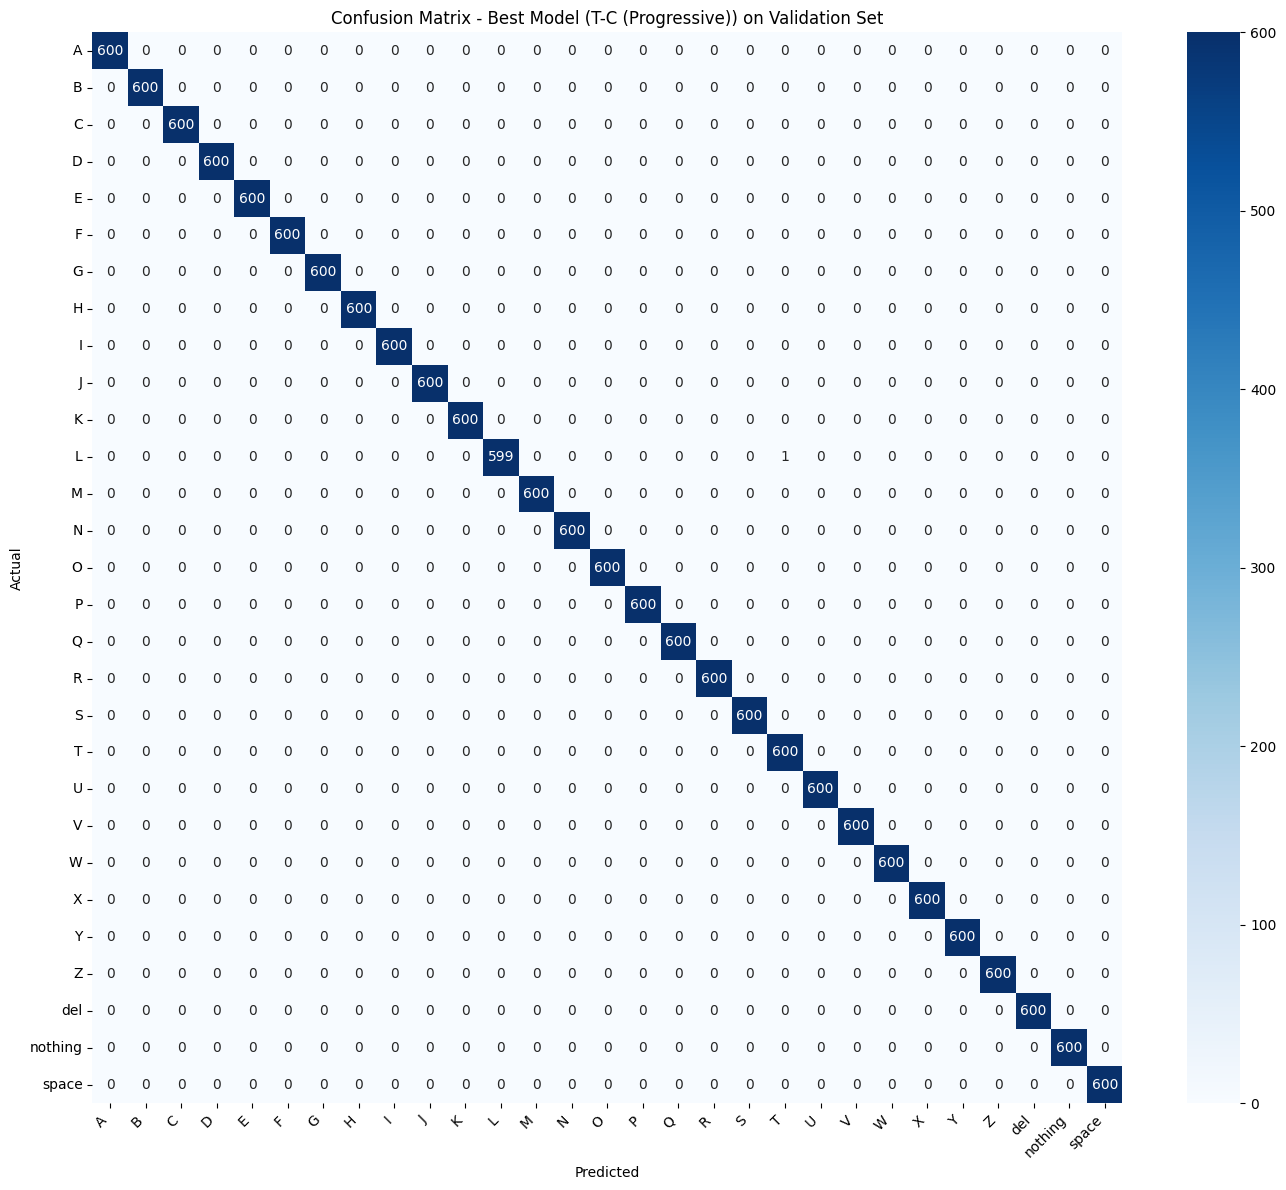

In [33]:
cm = confusion_matrix(val_labels, val_preds)
plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=full_dataset.classes, yticklabels=full_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - Best Model ({best_config[0]}) on Validation Set')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(f'{PROJECT_DIR}/confusion_matrix_val.png', dpi=150)
plt.show()

## 16. Test Set Evaluation (28 Images)

In [ ]:
class_to_idx = full_dataset.class_to_idx
# Evaluate on the official Kaggle test set (one image per class).
def evaluate_test_folder(model, test_dir, class_to_idx, transform):
    model.eval()
    all_preds = []
    all_labels = []
    correct = 0
    total = 0

    if not os.path.exists(test_dir):
        print(f"Test directory not found: {test_dir}")
        return None, None, None

    for filename in os.listdir(test_dir):
        if not filename.endswith(('.jpeg')):
            continue

        label_name = filename.split('_')[0].upper()
        if label_name == 'NOTHING':
            label_name = 'nothing'
        elif label_name == 'SPACE':
            label_name = 'space'
        elif label_name == 'DEL':
            label_name = 'del'

        if label_name not in class_to_idx:
            print(f"Unknown class: {label_name} from file {filename}")
            continue

        label = class_to_idx[label_name]

        img_path = os.path.join(test_dir, filename)
        image = Image.open(img_path).convert('RGB')
        image = transform(image).unsqueeze(0).to(DEVICE)

        with torch.no_grad():
            output = model(image)
            _, pred = output.max(1)

        all_preds.append(pred.item())
        all_labels.append(label)
        if pred.item() == label:
            correct += 1
        total += 1

    if total == 0:
        return None, None, None

    acc = correct / total
    f1 = f1_score(all_labels, all_preds, average='macro')

    return acc, f1, (np.array(all_preds), np.array(all_labels))

test_acc, test_f1, test_results = evaluate_test_folder(
    best_model, TEST_DIR, class_to_idx, val_transform
)

print("\n" + "="*60)
print("TEST SET EVALUATION (28 Images)")
print("="*60)
if test_acc is not None:
    print(f"Accuracy: {test_acc:.4f}")
    print(f"Macro-F1: {test_f1:.4f}")
else:
    print("Test set evaluation failed.")


TEST SET EVALUATION (28 Images)
Accuracy: 1.0000
Macro-F1: 1.0000


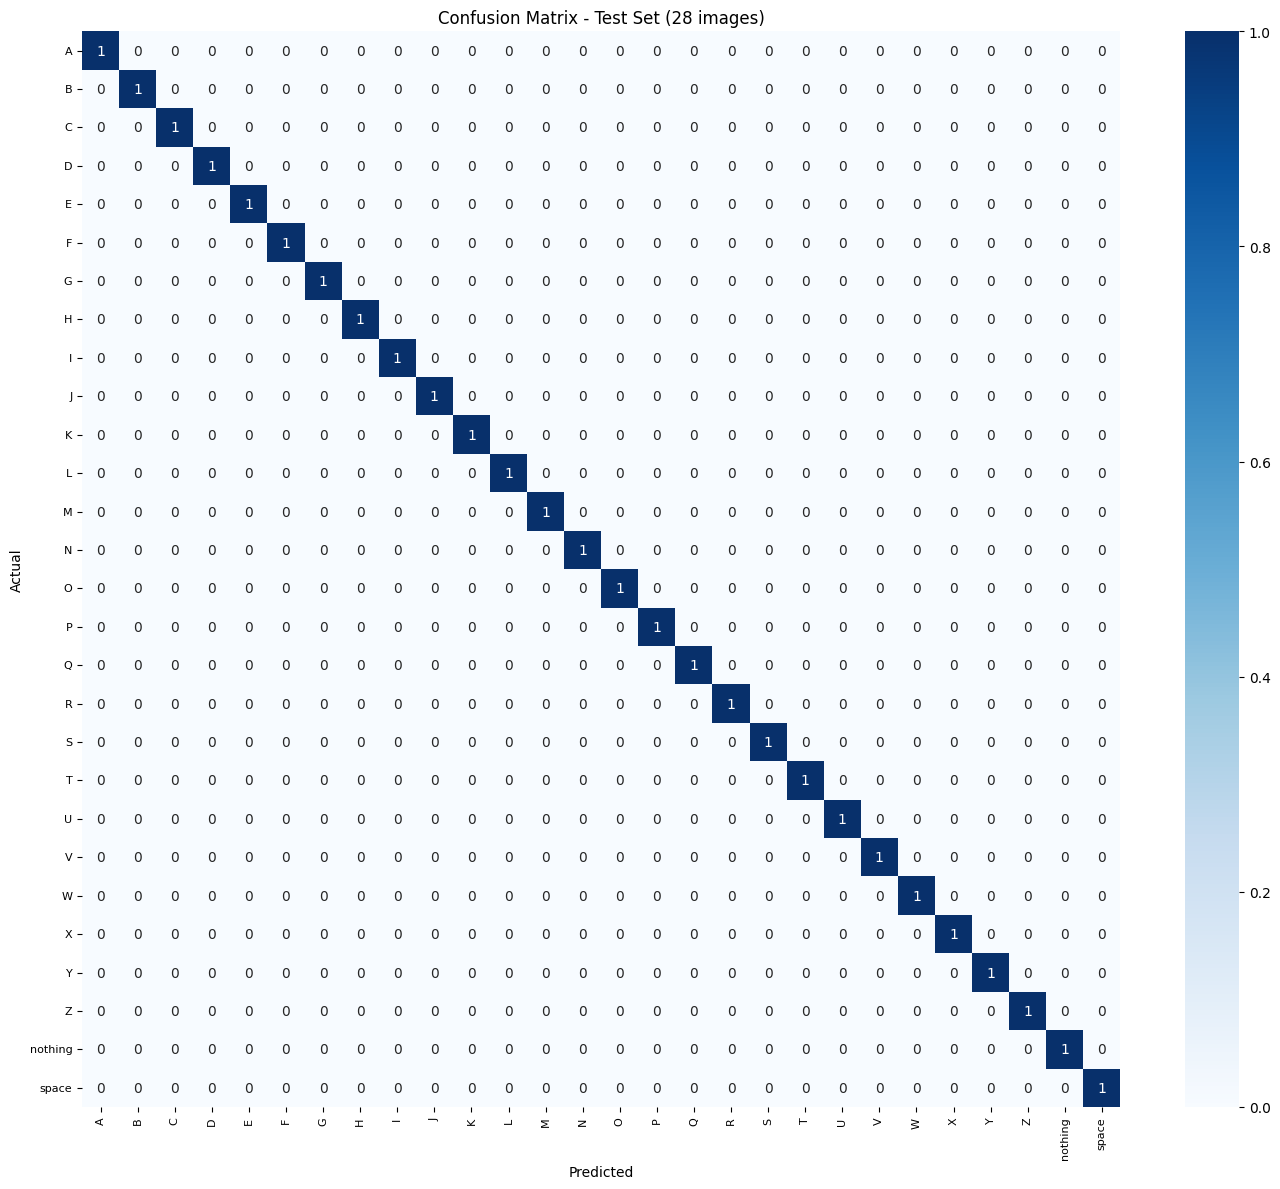

In [ ]:
# Test Set Confsuion Matrix
test_preds, test_labels = test_results

# Get only classes that appear in test set
unique_labels = sorted(set(test_labels))
idx_to_class = {v: k for k, v in class_to_idx.items()}
FILTERED_NAMES = [idx_to_class[i] for i in unique_labels]

cm = confusion_matrix(test_labels, test_preds, labels=unique_labels)
plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=FILTERED_NAMES, yticklabels=FILTERED_NAMES)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Test Set (28 images)')
plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.savefig(f'confusion_matrix_test.png', dpi=150)
plt.show()

In [ ]:
def preprocess_custom_image(img_path, output_path):
    img = Image.open(img_path)
    # Apply EXIF orientation (keeps original rotation from phone when getting loaded)
    img = ImageOps.exif_transpose(img)
    
    # Center crop to square
    w, h = img.size
    size = min(w, h)
    left, top = (w - size) // 2, (h - size) // 2
    img = img.crop((left, top, left + size, top + size))
    
    img.save(output_path)

# Process all custom images
CUSTOM_RAW_DIR = CUSTOM_TEST_DIR  # Original custom images
CUSTOM_PROCESSED_DIR = 'data/asl_custom_processed'
os.makedirs(CUSTOM_PROCESSED_DIR, exist_ok=True)

for f in os.listdir(CUSTOM_RAW_DIR):
    preprocess_custom_image(os.path.join(CUSTOM_RAW_DIR, f), os.path.join(CUSTOM_PROCESSED_DIR, f))
    print(f'Processed: {f}')

print(f'\nProcessed images saved to: {CUSTOM_PROCESSED_DIR}')

Processed: O_1.jpeg
Processed: C_1.jpeg
Processed: J_2.jpeg
Processed: R_2.jpeg
Processed: A_1.jpeg
Processed: H_2.jpeg
Processed: Q_1.jpeg
Processed: I_1.jpeg
Processed: E_1.jpeg
Processed: G_1.jpeg
Processed: K_1.jpeg
Processed: N_1.jpeg
Processed: G_2.jpeg
Processed: I_2.jpeg
Processed: L_1.jpeg
Processed: H_1.jpeg
Processed: A_2.jpeg
Processed: P_1.jpeg
Processed: J_1.jpeg
Processed: R_1.jpeg

Processed images saved to: data/asl_custom_processed


## 17. Custom Test Set Evaluation


In [94]:
custom_acc, custom_f1, custom_results = evaluate_test_folder(best_model, 'data/asl_custom_processed', class_to_idx, val_transform)
print("CUSTOM TEST SET EVALUATION")

print(f"Accuracy: {custom_acc:.4f}")
print(f"Macro-F1: {custom_f1:.4f}")

CUSTOM TEST SET EVALUATION
Accuracy: 0.8500
Macro-F1: 0.8333


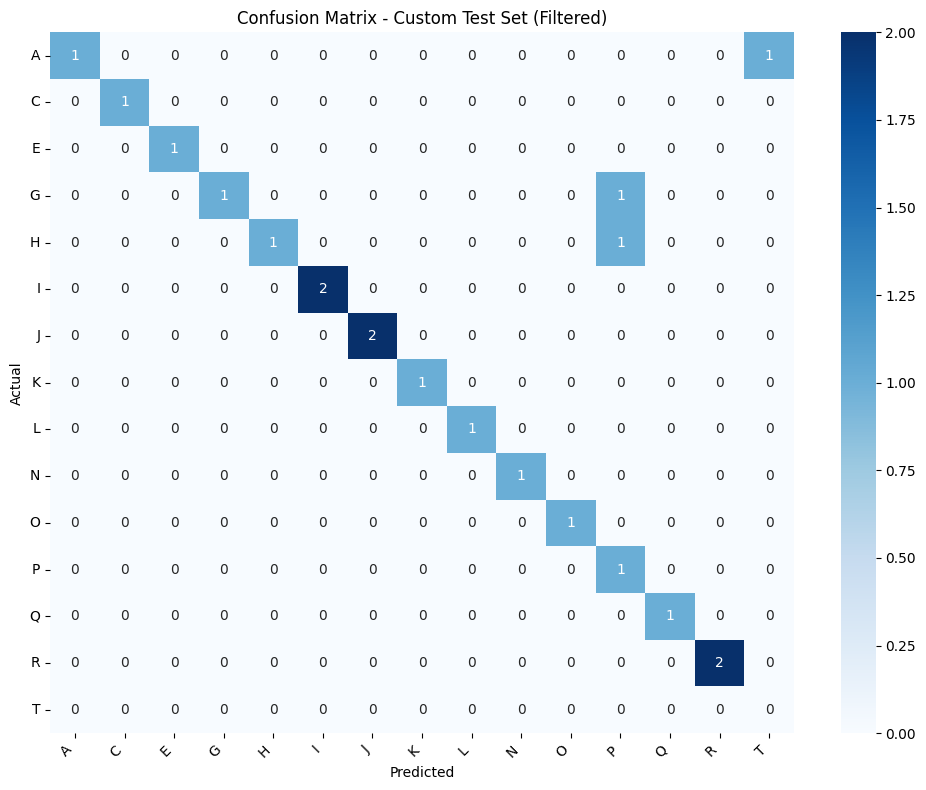

In [ ]:
# Custom Test Set Confusion Matrix

custom_preds, custom_labels = custom_results

present_indices = sorted(list(set(custom_labels) | set(custom_preds)))
present_class_names = [full_dataset.classes[i] for i in present_indices]

# Generate Matrix 
cm_filtered = confusion_matrix(
    custom_labels, 
    custom_preds, 
    labels=present_indices 
)

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm_filtered, annot=True, fmt='d', cmap='Blues', xticklabels=present_class_names, yticklabels=present_class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - Custom Test Set (Filtered)')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

plt.show()